## Import Data

In [1]:
import matplotlib.pylab as plt
import numpy as np
from tqdm.notebook import trange
import json
from tqdm import tnrange

In [3]:
%run "Kyber Leakage Model.ipynb"

0x1df082
0x1df082
0x4084692
0b11111111001101101010100101111110
0b00000000110010010101011010000010
13194882
3966
0xff36a97e
0x8ba0000
2226
0b00000000000000000000100010110010
0b11111111111111111111011101001110


In [6]:
#[[plaintext, cipher, tracearray], ...]
data = np.load('dataNewTrigger.npy', allow_pickle=True)
print(data[0][0])

[32, 195, 29, 129, 121, 202, 84, 235, 183, 73, 213, 254, 228, 63, 202, 156, 50, 51, 148, 35, 72, 216, 223, 226, 253, 185, 2, 188, 24, 143, 206, 39]


In [150]:
data_phase192 = np.load('data_phase192.npy', allow_pickle=True)

In [156]:
data_clkx2 = np.load('data_clkx2.npy', allow_pickle=True)

In [93]:
data_Trigger_low = np.load('data_trigger_low.npy', allow_pickle=True)
print(data_Trigger_low[0][0])

[241, 144, 50, 179, 87, 248, 201, 10, 173, 89, 32, 127, 247, 19, 148, 34, 235, 182, 86, 122, 235, 115, 143, 242, 11, 39, 49, 174, 108, 24, 144, 124]


In [91]:
data_falling_edge = np.load('data_falling_edge.npy', allow_pickle=True)
print(data_falling_edge[0][0])

[241, 144, 50, 179, 87, 248, 201, 10, 173, 89, 32, 127, 247, 19, 148, 34, 235, 182, 86, 122, 235, 115, 143, 242, 11, 39, 49, 174, 108, 24, 144, 124]


In [103]:
data_high = np.load('data_high.npy', allow_pickle=True)

In [109]:
data_low = np.load('data_low.npy', allow_pickle=True)

In [122]:
data_fetl = np.load('data_falling_edge_trigger_low.npy', allow_pickle=True)

## CPA Model

In [4]:
import numpy as np

def mean(X):
    return np.sum(X, axis=0)/len(X)

def std_dev(X, X_bar):
    return np.sqrt(np.sum((X-X_bar)**2, axis=0))

def cov(X, X_bar, Y, Y_bar):
    return np.sum((X-X_bar)*(Y-Y_bar), axis=0)

In [4]:

maxcpa = [0] * 65536

trace_array = [x[2] for x in data]
# we don't need to redo the mean and std dev calculations 
# for each key guess
t_bar = mean(trace_array) 
o_t = std_dev(trace_array, t_bar)

for kguess in tnrange(0, 2**16):
    hws = np.array([[getHammingSteg1(ctPoly(d[1], 0), kguess, 0) for d in data]]).transpose()
    #print(ctPoly(d[1], 0))
    #print(getHammingSteg1(ctPoly(d[1], 0), kguess, 0))
    #print(hws)
    hws_bar = mean(hws)
    o_hws = std_dev(hws, hws_bar)
    correlation = cov(trace_array, t_bar, hws, hws_bar)
    cpaoutput = correlation/(o_t*o_hws)
    maxcpa[kguess] = max(abs(cpaoutput))
    

guess = np.argmax(maxcpa)
guess_corr = max(maxcpa)
# ###################
# END SOLUTION
# ###################
print("Key guess: ", hex(guess))
print("Correlation: ", guess_corr)
print("Fasit", hex(0x77e), "corr:", maxcpa[0x77e])

/var/folders/7s/v6w1gfl95vng5ycdwyfdkmr00000gq/T/ipykernel_1690/894505924.py:10: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for kguess in tnrange(0, 2**16):


  0%|          | 0/65536 [00:00<?, ?it/s]

/var/folders/7s/v6w1gfl95vng5ycdwyfdkmr00000gq/T/ipykernel_1690/894505924.py:18: RuntimeWarning: invalid value encountered in divide
  cpaoutput = correlation/(o_t*o_hws)


<IPython.core.display.Javascript object>


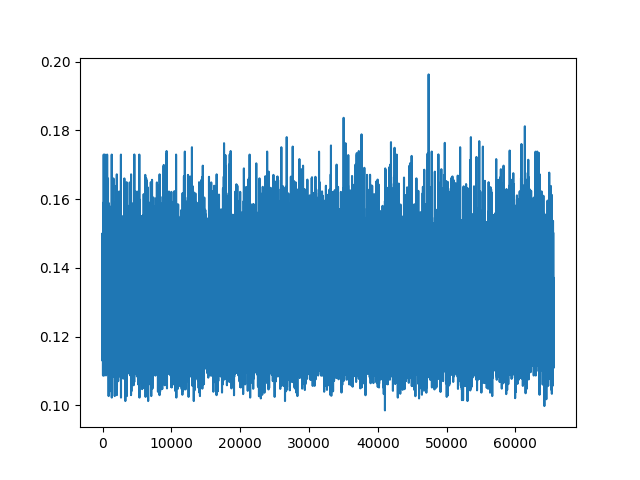

In [12]:
%matplotlib notebook

plt.plot(maxcpa)

## Steg 2

In [ ]:
keys = [0x77e]
maxcpa = [0] * len(keys)
for i in range(len(keys)):
    maxcpa[i] = [0] * 65536
    for kguess in tnrange(0, 2**16):
        hws = np.array([[getHammingSteg2(ctPoly(d[1], 0), key[i], kguess, 0) for d in data]]).transpose()

        hws_bar = mean(hws)
        o_hws = std_dev(hws, hws_bar)
        covariance = cov(trace_array, t_bar, hws, hws_bar)
        correalation = covariance/(o_t*o_hws)
        maxcpa[i][kguess] = max(abs(correalation))

### Saving data

In [55]:
with open("maxcpa20000", "w") as fp:
    json.dump(maxcpa, fp)

### Loading data

In [3]:
with open("maxcpa20000", "r") as fp:
    maxcpa = json.load(fp)

## Testing data

### Obtaining top key guesses

Selv om lavere correalation gir data med flere dekrypteringer bedre korrelasjon i forhold til andre

In [23]:
with open("maxcpa-multi", "r") as fp:
    maxcpa = json.load(fp)
print(maxcpa[0x77e]) 

0.43149708583420066


In [25]:
guesses = []
for i in range(len(maxcpa)):
    if maxcpa[i]>=.29:
        guesses.append(i)

In [26]:
print(len(guesses))

3776


#### Cheking correlation number for all subkeys

In [165]:
trace_array = [x[2] for x in data_clkx2]
t_bar = mean(trace_array) 
o_t = std_dev(trace_array, t_bar)

correalationForSubkeys_clkx2 = []

for i in tnrange(KYBER_N // 4):
    tmp = getTrueSk(sk, i)
    
    #double 1
    hws = np.array([[getHammingSteg1(ctPoly(d[1], 0), tmp[1], i) for d in data_clkx2]]).transpose()
    hws_bar = mean(hws)
    o_hws = std_dev(hws, hws_bar)
    correlation = cov(trace_array, t_bar, hws, hws_bar)
    cpaoutput = abs(correlation/(o_t*o_hws))
    corr = [cpaoutput.argmax(), max(cpaoutput)]
    correalationForSubkeys_clkx2.append(corr)
    print(corr, end='\r')
    
    
    #double 2
    hws = np.array([[getHammingSteg12(ctPoly(d[1], 0), tmp[3], i) for d in data_clkx2]]).transpose()
    hws_bar = mean(hws)
    o_hws = std_dev(hws, hws_bar)
    correlation = cov(trace_array, t_bar, hws, hws_bar)
    cpaoutput = abs(correlation/(o_t*o_hws))
    corr = [cpaoutput.argmax(), max(cpaoutput)]
    correalationForSubkeys_clkx2.append(corr)
    print(corr, end='\r')
    

C:\Users\erlen\AppData\Local\Temp\ipykernel_9312\2927653765.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(KYBER_N // 4):


  0%|          | 0/64 [00:00<?, ?it/s]

In [163]:
sum1 = 0
sum2 = 0
sum3 = 0
sum4 = 0
for i in range(len(correalationForSubkeys)):
    sum1+=correalationForSubkeys[i][1] 
    sum2+=correalationForSubkeys_phase192[i][1]
    sum3+=correalationForSubkeys_clkx2[i][1]
    sum4+=correalationForSubkeys_high[i][1]
print(sum1/len(correalationForSubkeys), sum2/len(correalationForSubkeys), sum3/len(correalationForSubkeys), sum4/len(correalationForSubkeys))

0.32880325383062897 0.37298297397511343 0.3713544616094032 0.22219508573644275


In [158]:
for i in range(len(correalationForSubkeys)):
    print(correalationForSubkeys[i],  correalationForSubkeys_phase192[i], correalationForSubkeys_clkx2[i])

[233, 0.43149708583420066] [234, 0.4399680132763816] [233, 0.44629974514934645]
[285, 0.39457298405550234] [288, 0.4080110850657796] [285, 0.41308615737388654]
[609, 0.38599021219318147] [611, 0.3822158305389737] [610, 0.3678157642548171]
[663, 0.38569668474410246] [663, 0.36950403573953017] [662, 0.34956249655186766]
[985, 0.388520621304478] [985, 0.5087882914831255] [986, 0.5009431572758305]
[1038, 0.27392118569700696] [1037, 0.3390776480621453] [1040, 0.3399947840627415]
[1362, 0.375097111710101] [1361, 0.40929797175830196] [1362, 0.39117657568695247]
[1413, 0.42596525678044017] [1414, 0.5147832809496796] [1415, 0.5186400682314697]
[1738, 0.352770195019823] [1738, 0.34696765702896953] [1739, 0.38071251100065606]
[1789, 0.3242615088130053] [1789, 0.40122833959498494] [1789, 0.397147185572703]
[2113, 0.3850061985227507] [2115, 0.4182366092031236] [2114, 0.4052982532378648]
[2166, 0.37004813999861336] [2167, 0.3431455509285871] [2165, 0.3512266700791646]
[2489, 0.3256736866586791] [248

In [137]:
print(correalationForSubkeys[0], correalationForSubkeys2[0], correalationForSubkeys3[0])

[233, 0.43149708583420066] [234, 0.4349447404003588] [233, 0.45435027421442187]


### Testing correlation equations 
by inserting known correalation

In [25]:
trace_array = [x[2] for x in data]
hws = np.array([[getHammingSteg1(ctPoly(d[1], 0), 0x77e, 0) for d in data]]).transpose()

for i in range(1000):
    trace_array[i][5000] = hws[i] #Known correlation of 1

t_bar = mean(trace_array) 
o_t = std_dev(trace_array, t_bar)
hws_bar = mean(hws)
o_hws = std_dev(hws, hws_bar)

correlation = cov(trace_array, t_bar, hws, hws_bar)
cpaoutput = correlation/(o_t*o_hws)

print(np.nanmax(cpaoutput))

0.9999999999999993


<IPython.core.display.Javascript object>


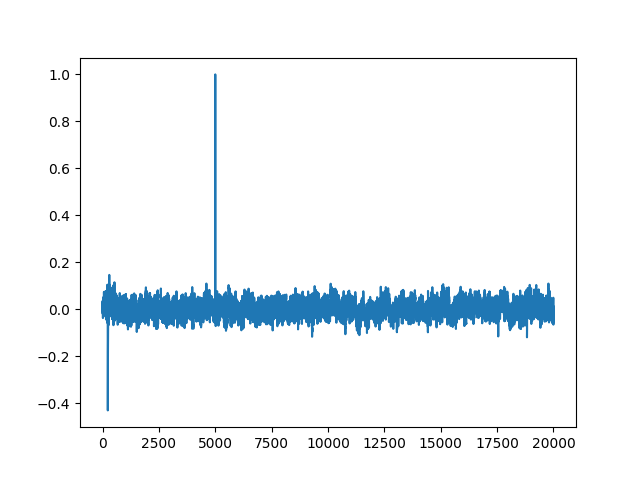

In [26]:
%matplotlib notebook

plt.plot(cpaoutput)

## Testing leakage model
Mot fasit som burde få høy correalation

In [14]:
%run "Kyber Leakage Model.ipynb"

0x1df082
0xff36a97e
0xfbb90000
0xffdacea2
0x5622da
0x5622da
0x1c4ef26
0xff7b0000
0x834ba2
0x3d6ee5e
0xff9e0000
0xff9eff7b
2226
0b00000000000000000000100010110010
0b11111111111111111111011101001110


### Del 1

In [11]:
trace_array = [x[2] for x in data]
hws = np.array([[getHammingSteg1(ctPoly(d[1], 0), 0x77e, 0) for d in data]]).transpose()

t_bar = mean(trace_array) 
o_t = std_dev(trace_array, t_bar)
hws_bar = mean(hws)
o_hws = std_dev(hws, hws_bar)

correlation = cov(trace_array, t_bar, hws, hws_bar)
cpaoutput = correlation/(o_t*o_hws)

print(np.nanmax(abs(cpaoutput)))

0.43149708583420066


<IPython.core.display.Javascript object>


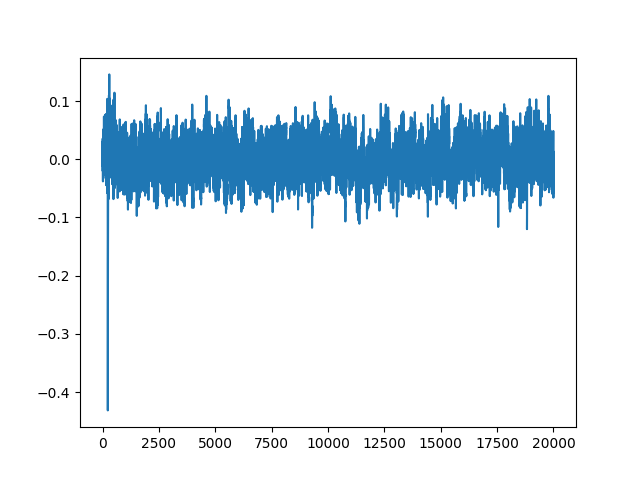

In [12]:
%matplotlib notebook

plt.plot(cpaoutput)

### Del 2

In [15]:
trace_array = [x[2] for x in data]
hws = np.array([[getHammingSteg2(ctPoly(d[1], 0), 0x77e, 0xa36, 0) for d in data]]).transpose()

t_bar = mean(trace_array) 
o_t = std_dev(trace_array, t_bar)
hws_bar = mean(hws)
o_hws = std_dev(hws, hws_bar)

correlation = cov(trace_array, t_bar, hws, hws_bar)
cpaoutput = correlation/(o_t*o_hws)

print(np.nanmax(abs(cpaoutput)))

0.9437365140133332
